In [1]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

C:\Users\yeji4\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\yeji4\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\yeji4\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [66]:
train = pd.read_csv("pre_ver10/pre_train.csv", index_col = 0)
test = pd.read_csv("pre_ver10/pre_test.csv", index_col = 0)
train

building_number  temperature  windspeed  humidity  power_consumption  \
0                     1         18.6        0.9      42.0            1085.28   
1                     1         18.0        1.1      45.0            1047.36   
2                     1         17.7        1.5      45.0             974.88   
3                     1         16.7        1.4      48.0             953.76   
4                     1         18.4        2.8      43.0             986.40   
...                 ...          ...        ...       ...                ...   
203995              100         23.1        0.9      86.0             881.04   
203996              100         22.4        1.3      86.0             798.96   
203997              100         21.3        1.0      92.0             825.12   
203998              100         21.0        0.3      94.0             640.08   
203999              100         20.7        0.1      95.0             540.24   

        day  month  day_of_week  cos_time  sin_time  holiday  weekend  \
0         1      6            2  1.000000  0.000000    False    False   
1         1      6            2  0.965926  0.258819    False    False   
2         1      6            2  0.866025  0.500000    False    False   
3         1      6            2  0.707107  0.707107    False    False   
4         1      6            2  0.500000  0.866025    False    False   
...     ...    ...          ...       ...       ...      ...      ...   
203995   24      8            2  0.258819 -0.965926    False    False   
203996   24      8            2  0.500000 -0.866025    False    False   
203997   24      8            2  0.707107 -0.707107    False    False   
203998   24      8            2  0.866025 -0.500000    False    False   
203999   24      8            2  0.965926 -0.258819    False    False   

        discomfort  discomfort_3   CDH  sensory_temperature  \
0         63.09388       0.00000  -7.4            20.751584   
1         62.46400       0.00000 -15.4            20.008954   
2         62.08735       0.00000 -23.7            19.476910   
3         60.89884      -2.19504 -33.0            18.487958   
4         62.88788       0.42388 -40.6            19.751534   
...            ...           ...   ...                  ...   
203995    72.38034      -2.60734 -19.6            25.302757   
203996    71.21736      -4.15064 -20.2            24.446518   
203997    69.79704      -4.64022 -22.3            23.433400   
203998    69.41060      -2.96974 -25.1            23.661275   
203999    68.95035      -2.26701 -28.1            23.797169   

        month_day_hour_mean  day_hour_mean    hour_mean    hour_std  
0                  1174.656    1774.744615  1706.318118  446.882767  
1                  1101.600    1687.347692  1622.620235  439.662704  
2                  1025.760    1571.483077  1506.971294  412.071906  
3                  1015.584    1522.153846  1437.365647  391.205981  
4                  1041.792    1506.793846  1447.321412  381.099696  
...                     ...            ...          ...         ...  
203995             1067.700     964.873846  1010.462118  161.399578  
203996              951.300     882.184615   928.125176  137.566008  
203997              857.760     779.095385   830.032941  128.300189  
203998              717.240     663.267692   723.100235  112.464079  
203999              616.500     561.932308   588.784941   91.484424  

[204000 rows x 20 columns]

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   building_number      204000 non-null  int64  
 1   temperature          204000 non-null  float64
 2   windspeed            204000 non-null  float64
 3   humidity             204000 non-null  float64
 4   power_consumption    204000 non-null  float64
 5   day                  204000 non-null  int64  
 6   month                204000 non-null  int64  
 7   day_of_week          204000 non-null  int64  
 8   cos_time             204000 non-null  float64
 9   sin_time             204000 non-null  float64
 10  holiday              204000 non-null  bool   
 11  weekend              204000 non-null  bool   
 12  discomfort           204000 non-null  float64
 13  discomfort_3         204000 non-null  float64
 14  CDH                  204000 non-null  float64
 15  sensory_temperatu

In [3]:
train_1 = train
test_1 = test

# 카테고리 컬럼 설정
# train_1[['building_type']] = train_1[[ 'building_type']].astype('category')

# train_1 = pd.get_dummies(train_1, columns = ['building_type'])

# 특성과 라벨 분리
y = train_1.loc[train['building_number'] == 1, 'power_consumption']
x = train_1.loc[train['building_number'] == 1].drop(columns = ['building_number','power_consumption', 'weekend'])

In [4]:
# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(np.array(x))

# scaler = RobustScaler()
# X_train_scaled_1 = scaler.fit_transform(x)

# 데이터 분할
y_train, y_valid, X_train_scaled_1, x_valid = temporal_train_test_split(y = y, X = X_train_scaled_1, test_size = 168)

# XGBoost 모델 생성
xgb_model_1 = XGBRegressor(objective='reg:squarederror', random_state=42)

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_1.fit(X_train_scaled_1,y_train )

pred = xgb_model_1.predict(x_valid)
print(f"[Test #1] SMAPE: {smape(y_valid, pred)}")

[Test #1] SMAPE: 6.642822863611947


In [5]:
feature_importance = pd.DataFrame(xgb_model_1.feature_importances_.reshape((1, -1)), columns=x.columns, index=['feature_importance'])
feature_importance = feature_importance.transpose()
feature_importance

feature_importance
temperature                    0.001260
windspeed                      0.000954
humidity                       0.005098
day                            0.008574
month                          0.096862
day_of_week                    0.024977
cos_time                       0.665100
sin_time                       0.150368
holiday                        0.014686
discomfort                     0.025872
discomfort_3                   0.000795
CDH                            0.004256
sensory_temperature            0.001197

In [8]:
test

building_number  temperature  windspeed  humidity  day  month  \
0                    1         23.5        2.2        72   25      8   
1                    1         23.0        0.9        72   25      8   
2                    1         22.7        1.5        75   25      8   
3                    1         22.1        1.3        78   25      8   
4                    1         21.8        1.0        77   25      8   
...                ...          ...        ...       ...  ...    ...   
16795              100         22.5        0.9        84   31      8   
16796              100         20.7        0.4        95   31      8   
16797              100         20.2        0.4        98   31      8   
16798              100         20.1        1.1        97   31      8   
16799              100         19.1        0.1        99   31      8   

       day_of_week  cos_time  sin_time  holiday  ...  \
0                3  1.000000  0.000000    False  ...   
1                3  0.965926  0.258819    False  ...   
2                3  0.866025  0.500000    False  ...   
3                3  0.707107  0.707107    False  ...   
4                3  0.500000  0.866025    False  ...   
...            ...       ...       ...      ...  ...   
16795            2  0.258819 -0.965926    False  ...   
16796            2  0.500000 -0.866025    False  ...   
16797            2  0.707107 -0.707107    False  ...   
16798            2  0.866025 -0.500000    False  ...   
16799            2  0.965926 -0.258819    False  ...   

       building_type_Data Center  building_type_Department Store and Outlet  \
0                              0                                          0   
1                              0                                          0   
2                              0                                          0   
3                              0                                          0   
4                              0                                          0   
...                          ...                                        ...   
16795                          0                                          0   
16796                          0                                          0   
16797                          0                                          0   
16798                          0                                          0   
16799                          0                                          0   

       building_type_Discount Mart  building_type_Hospital  \
0                                0                       0   
1                                0                       0   
2                                0                       0   
3                                0                       0   
4                                0                       0   
...                            ...                     ...   
16795                            0                       0   
16796                            0                       0   
16797                            0                       0   
16798                            0                       0   
16799                            0                       0   

       building_type_Hotel and Resort  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   
...                               ...   
16795                               1   
16796                               1   
16797                               1   
16798                               1   
16799                               1   

       building_type_Knowledge Industry Center  building_type_Other Buildings  \
0                                            0                              1   
1                                            0                              1   
2                                      

In [9]:

X_test_scaled = scaler.fit_transform(test)
preds = xgb_model_1.predict(X_test_scaled)
sub = pd.read_csv("sample_submission.csv")
sub

num_date_time  answer
0        1_20220825 00       0
1        1_20220825 01       0
2        1_20220825 02       0
3        1_20220825 03       0
4        1_20220825 04       0
...                ...     ...
16795  100_20220831 19       0
16796  100_20220831 20       0
16797  100_20220831 21       0
16798  100_20220831 22       0
16799  100_20220831 23       0

[16800 rows x 2 columns]

In [10]:
sub['answer'] = preds
sub

num_date_time       answer
0        1_20220825 00  2274.902832
1        1_20220825 01  2188.788574
2        1_20220825 02  2119.407471
3        1_20220825 03  2125.522949
4        1_20220825 04  2197.880371
...                ...          ...
16795  100_20220831 19  2187.440674
16796  100_20220831 20  2064.507812
16797  100_20220831 21  1995.119751
16798  100_20220831 22  1923.924805
16799  100_20220831 23  1884.823975

[16800 rows x 2 columns]

In [12]:
sub.to_csv("submission_xgb_02.csv", index = 0)

train data shape
x:(1872, 15), y:(1872,)


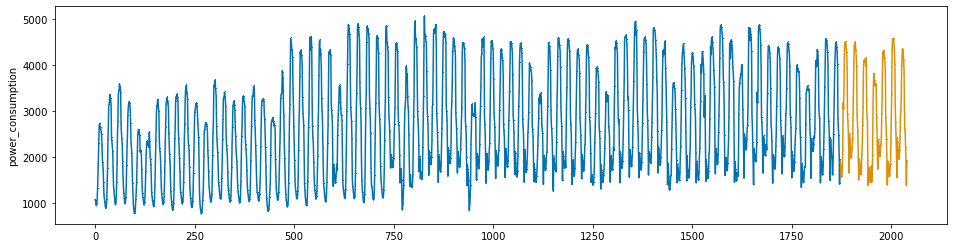

In [133]:
y = train_1.loc[train['building_number'] == 1, 'power_consumption']
x = train_1.loc[train['building_number'] == 1].drop(columns = 'power_consumption')

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [7]:
def SMAPE(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

## hyperparameter tuning:GridSearchCV

In [8]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from tqdm import tqdm
df = pd.DataFrame(columns = ['eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

# 수정 전
# grid = {'n_estimators' : [100], 'eta' : [0.01, 0.3], 'min_child_weight' : np.arange(1, 8, 1), 
#         'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.2, 1.0, 0.2), 
#         'subsample' :np.arange(0.4, 1.0, 0.2)}
# 수정 후
grid = {'eta' : [0.01, 0.3], 'min_child_weight' : np.arange(1, 8, 1), 
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.2, 1.0, 0.2), 
        'subsample' :np.arange(0.4, 1.0, 0.2)}

for i in tqdm(np.arange(1, 101)):
    y = train_1.loc[train['building_number'] == i, 'power_consumption']
    x = train_1.loc[train['building_number'] == i].drop(columns = 'power_consumption')
    #y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    
    smape = make_scorer(SMAPE, greater_is_better = False)
    pds = PredefinedSplit(np.append(-np.ones(len(x_scaled)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 0),
                       param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = True)
    
    gcv.fit(x_scaled, y)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_scaled)
    building = 'building '+str(i)
    print(building + ' || SMAPE : {}'.format(SMAPE(y, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('./hyperparameter_xgb.csv', index = False)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  1%|▊                                                                               | 1/100 [01:00<1:40:37, 60.99s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 1 || SMAPE : 3.030119850589946
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  2%|█▌                                                                              | 2/100 [02:02<1:39:52, 61.15s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6000000000000001}
building 2 || SMAPE : 0.9613839889598299
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  3%|██▍                                                                             | 3/100 [03:03<1:39:00, 61.24s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.8000000000000002}
building 3 || SMAPE : 0.9437646028929149
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  4%|███▏                                                                            | 4/100 [03:59<1:34:41, 59.18s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 4 || SMAPE : 0.3022665374380912
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  5%|████                                                                            | 5/100 [05:01<1:34:58, 59.98s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 5 || SMAPE : 2.3980375766881594
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  6%|████▊                                                                           | 6/100 [06:00<1:33:48, 59.88s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8000000000000002}
building 6 || SMAPE : 1.0836648871506962
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  7%|█████▌                                                                          | 7/100 [07:01<1:33:16, 60.17s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 7 || SMAPE : 0.53945591088092
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  8%|██████▍                                                                         | 8/100 [07:54<1:28:44, 57.87s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8000000000000002}
building 8 || SMAPE : 1.0771091152191163
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


  9%|███████▏                                                                        | 9/100 [08:53<1:28:32, 58.38s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6000000000000001}
building 9 || SMAPE : 2.731642546439246
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 10%|███████▉                                                                       | 10/100 [09:50<1:26:30, 57.68s/it]

{'colsample_bytree': 0.4, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.4}
building 10 || SMAPE : 2.2844657191516573
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 11%|████████▋                                                                      | 11/100 [10:43<1:23:47, 56.49s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6000000000000001}
building 11 || SMAPE : 0.5783129311766737
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 12%|█████████▍                                                                     | 12/100 [11:41<1:23:13, 56.75s/it]

{'colsample_bytree': 0.4, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8000000000000002}
building 12 || SMAPE : 1.7672330676920267
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 13%|██████████▎                                                                    | 13/100 [12:33<1:20:20, 55.40s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 13 || SMAPE : 0.3670050855445791
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 14%|███████████                                                                    | 14/100 [13:30<1:20:16, 56.01s/it]

{'colsample_bytree': 0.4, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8000000000000002}
building 14 || SMAPE : 2.4814473008459874
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 15%|███████████▊                                                                   | 15/100 [14:23<1:17:45, 54.89s/it]

{'colsample_bytree': 0.6000000000000001, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8000000000000002}
building 15 || SMAPE : 1.5990554845213674
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 16%|████████████▋                                                                  | 16/100 [15:21<1:18:18, 55.94s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 16 || SMAPE : 3.5079435062908115
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 17%|█████████████▍                                                                 | 17/100 [16:19<1:18:21, 56.64s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 17 || SMAPE : 0.4226998272745445
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 18%|██████████████▏                                                                | 18/100 [17:17<1:17:56, 57.03s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.4}
building 18 || SMAPE : 3.330173994760974
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 19%|███████████████                                                                | 19/100 [18:19<1:18:50, 58.40s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8000000000000002}
building 19 || SMAPE : 2.2415726482419407
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 20%|███████████████▊                                                               | 20/100 [19:20<1:18:53, 59.17s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 20 || SMAPE : 1.5925201518465202
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 21%|████████████████▌                                                              | 21/100 [20:18<1:17:35, 58.93s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6000000000000001}
building 21 || SMAPE : 2.8401807595819366
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 22%|█████████████████▍                                                             | 22/100 [21:14<1:15:16, 57.91s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6000000000000001}
building 22 || SMAPE : 0.5986431441977458
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 23%|██████████████████▏                                                            | 23/100 [22:08<1:13:02, 56.92s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8000000000000002}
building 23 || SMAPE : 0.3197912067633853
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 24%|██████████████████▉                                                            | 24/100 [23:06<1:12:19, 57.10s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8000000000000002}
building 24 || SMAPE : 0.7586929888555394
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 25%|███████████████████▊                                                           | 25/100 [24:04<1:11:39, 57.33s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8000000000000002}
building 25 || SMAPE : 1.3213618257373811
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 26%|████████████████████▌                                                          | 26/100 [25:00<1:10:29, 57.16s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 26 || SMAPE : 0.7821063021693692
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 27%|█████████████████████▎                                                         | 27/100 [25:56<1:08:50, 56.58s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6000000000000001}
building 27 || SMAPE : 0.947912915819615
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 28%|██████████████████████                                                         | 28/100 [26:53<1:08:14, 56.87s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6000000000000001}
building 28 || SMAPE : 2.2204655786387595
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 29%|██████████████████████▉                                                        | 29/100 [27:50<1:07:14, 56.82s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.4}
building 29 || SMAPE : 2.0527924973793565
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 30%|███████████████████████▋                                                       | 30/100 [28:49<1:06:55, 57.36s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 30 || SMAPE : 2.907719434880908
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 31%|████████████████████████▍                                                      | 31/100 [29:46<1:05:54, 57.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6000000000000001}
building 31 || SMAPE : 0.17345205880261272
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 32%|█████████████████████████▎                                                     | 32/100 [30:30<1:00:27, 53.34s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.4}
building 32 || SMAPE : 0.23125380005714677
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 33%|██████████████████████████▋                                                      | 33/100 [31:14<56:31, 50.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6000000000000001}
building 33 || SMAPE : 0.15169502499108511
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 34%|███████████████████████████▌                                                     | 34/100 [32:00<54:12, 49.28s/it]

{'colsample_bytree': 0.6000000000000001, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8000000000000002}
building 34 || SMAPE : 0.16367029026780797
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 35%|████████████████████████████▎                                                    | 35/100 [32:44<51:38, 47.67s/it]

{'colsample_bytree': 0.4, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.8000000000000002}
building 35 || SMAPE : 0.25820674677181105
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 36%|█████████████████████████████▏                                                   | 36/100 [33:27<49:15, 46.18s/it]

{'colsample_bytree': 0.6000000000000001, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6000000000000001}
building 36 || SMAPE : 0.3031154473730348
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 37%|█████████████████████████████▉                                                   | 37/100 [34:27<52:55, 50.41s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 37 || SMAPE : 0.7575435313100909
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 38%|██████████████████████████████▊                                                  | 38/100 [35:29<55:30, 53.72s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8000000000000002}
building 38 || SMAPE : 2.2293821385772015
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 39%|███████████████████████████████▌                                                 | 39/100 [36:30<56:59, 56.05s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8000000000000002}
building 39 || SMAPE : 2.5146388848680066
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 40%|████████████████████████████████▍                                                | 40/100 [37:31<57:36, 57.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 40 || SMAPE : 1.1195898589276052
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 41%|█████████████████████████████████▏                                               | 41/100 [38:33<57:41, 58.67s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6000000000000001}
building 41 || SMAPE : 3.2242753076865025
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 42%|██████████████████████████████████                                               | 42/100 [39:34<57:32, 59.53s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8000000000000002}
building 42 || SMAPE : 2.7913014673119836
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 43%|██████████████████████████████████▊                                              | 43/100 [40:36<57:16, 60.29s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.6000000000000001}
building 43 || SMAPE : 0.8384922495827436
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 44%|███████████████████████████████████▋                                             | 44/100 [41:37<56:30, 60.54s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8000000000000002}
building 44 || SMAPE : 2.32194718216017
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 45%|████████████████████████████████████▍                                            | 45/100 [42:33<54:07, 59.05s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8000000000000002}
building 45 || SMAPE : 1.2407688064212128
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 46%|█████████████████████████████████████▎                                           | 46/100 [43:31<52:52, 58.76s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.4}
building 46 || SMAPE : 2.608558005028762
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 47%|██████████████████████████████████████                                           | 47/100 [44:26<50:59, 57.73s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.4}
building 47 || SMAPE : 2.2040244709790415
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 48%|██████████████████████████████████████▉                                          | 48/100 [45:22<49:26, 57.05s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.4}
building 48 || SMAPE : 1.3962268308299746
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 49%|███████████████████████████████████████▋                                         | 49/100 [46:15<47:37, 56.02s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8000000000000002}
building 49 || SMAPE : 0.7007683171937622
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 50%|████████████████████████████████████████▌                                        | 50/100 [47:10<46:15, 55.51s/it]

{'colsample_bytree': 0.4, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.8000000000000002}
building 50 || SMAPE : 1.7122643530043284
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 51%|█████████████████████████████████████████▎                                       | 51/100 [48:06<45:36, 55.84s/it]

{'colsample_bytree': 0.4, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.8000000000000002}
building 51 || SMAPE : 2.521496146650622
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 52%|██████████████████████████████████████████                                       | 52/100 [49:05<45:17, 56.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.4}
building 52 || SMAPE : 2.6780957056505827
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 53%|██████████████████████████████████████████▉                                      | 53/100 [50:07<45:42, 58.35s/it]

{'colsample_bytree': 0.6000000000000001, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8000000000000002}
building 53 || SMAPE : 8.208590420178101
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 54%|███████████████████████████████████████████▋                                     | 54/100 [51:09<45:36, 59.48s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8000000000000002}
building 54 || SMAPE : 1.9551571722693073
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 55%|████████████████████████████████████████████▌                                    | 55/100 [51:59<42:21, 56.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6000000000000001}
building 55 || SMAPE : 0.36368701525081887
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 56%|█████████████████████████████████████████████▎                                   | 56/100 [52:45<39:17, 53.57s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8000000000000002}
building 56 || SMAPE : 0.39403217510460664
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 57%|██████████████████████████████████████████████▏                                  | 57/100 [53:46<39:51, 55.61s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8000000000000002}
building 57 || SMAPE : 1.656529828218754
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 58%|██████████████████████████████████████████████▉                                  | 58/100 [54:30<36:32, 52.21s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6000000000000001}
building 58 || SMAPE : 0.25480680105484244
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 59%|███████████████████████████████████████████████▊                                 | 59/100 [55:31<37:31, 54.92s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8000000000000002}
building 59 || SMAPE : 2.2570124938679865
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 60%|████████████████████████████████████████████████▌                                | 60/100 [56:31<37:32, 56.32s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.4}
building 60 || SMAPE : 4.116288345847597
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 61%|█████████████████████████████████████████████████▍                               | 61/100 [57:29<37:02, 56.98s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 61 || SMAPE : 2.0930164419379045
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 62%|██████████████████████████████████████████████████▏                              | 62/100 [58:28<36:24, 57.49s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.4}
building 62 || SMAPE : 1.9950172763021377
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 63%|███████████████████████████████████████████████████                              | 63/100 [59:27<35:40, 57.86s/it]

{'colsample_bytree': 0.4, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6000000000000001}
building 63 || SMAPE : 4.490769829135945
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:00:23<34:28, 57.46s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6000000000000001}
building 64 || SMAPE : 1.0870222268722431
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:01:24<34:09, 58.56s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 65 || SMAPE : 1.2644487970152833
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:02:21<32:52, 58.01s/it]

{'colsample_bytree': 0.6000000000000001, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.4}
building 66 || SMAPE : 1.694546905348341
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:03:19<31:47, 57.80s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 67 || SMAPE : 0.32787161601375225
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:04:17<30:53, 57.91s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8000000000000002}
building 68 || SMAPE : 0.25284522045220637
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:05:13<29:38, 57.38s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8000000000000002}
building 69 || SMAPE : 0.07839104949693285
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:06:12<28:54, 57.83s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6000000000000001}
building 70 || SMAPE : 1.1798396563494902
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 71%|████████████████████████████████████████████████████████                       | 71/100 [1:07:10<28:01, 57.99s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8000000000000002}
building 71 || SMAPE : 2.3759942715580484
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:08:03<26:24, 56.59s/it]

{'colsample_bytree': 0.4, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.4}
building 72 || SMAPE : 2.0547796466763715
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:08:57<25:02, 55.64s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.4}
building 73 || SMAPE : 1.4520305968553482
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:09:56<24:37, 56.81s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8000000000000002}
building 74 || SMAPE : 0.8648565041822154
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:10:53<23:42, 56.90s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8000000000000002}
building 75 || SMAPE : 1.9339483860910172
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:11:49<22:35, 56.50s/it]

{'colsample_bytree': 0.6000000000000001, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.4}
building 76 || SMAPE : 2.8771844694280255
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:12:48<21:54, 57.16s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 77 || SMAPE : 1.4258513190789939
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:13:47<21:14, 57.94s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8000000000000002}
building 78 || SMAPE : 2.578850886834254
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:14:45<20:17, 57.96s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6000000000000001}
building 79 || SMAPE : 1.675843723501968
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:15:47<19:39, 58.96s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 80 || SMAPE : 0.6895944877998318
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:16:47<18:47, 59.34s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8000000000000002}
building 81 || SMAPE : 3.4345406101068057
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:17:50<18:08, 60.45s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8000000000000002}
building 82 || SMAPE : 2.3246621231428803
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:18:51<17:12, 60.74s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6000000000000001}
building 83 || SMAPE : 1.4698399666640616
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:19:52<16:11, 60.72s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8000000000000002}
building 84 || SMAPE : 0.585833896589159
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:20:47<14:44, 58.99s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6000000000000001}
building 85 || SMAPE : 0.3501996403286542
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:21:47<13:51, 59.37s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.4}
building 86 || SMAPE : 3.019265994026357
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:22:49<13:02, 60.18s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 87 || SMAPE : 0.29842764240890796
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:23:51<12:07, 60.59s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6000000000000001}
building 88 || SMAPE : 1.0714590596489446
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:24:53<11:10, 60.95s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8000000000000002}
building 89 || SMAPE : 1.3791000396016175
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:25:55<10:13, 61.36s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8000000000000002}
building 90 || SMAPE : 1.964175846042916
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:26:57<09:14, 61.58s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8000000000000002}
building 91 || SMAPE : 0.5197877469815373
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:27:58<08:11, 61.40s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8000000000000002}
building 92 || SMAPE : 0.6907414803895652
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:28:55<07:01, 60.17s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.4}
building 93 || SMAPE : 2.3688492250861155
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:29:53<05:55, 59.32s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.6000000000000001}
building 94 || SMAPE : 1.390739620204359
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:30:50<04:52, 58.55s/it]

{'colsample_bytree': 0.6000000000000001, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6000000000000001}
building 95 || SMAPE : 5.486560486126217
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:31:44<03:49, 57.28s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.4}
building 96 || SMAPE : 0.6001529987570797
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:32:40<02:50, 56.82s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6000000000000001}
building 97 || SMAPE : 0.6112390636129051
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:33:37<01:53, 56.89s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.4}
building 98 || SMAPE : 6.03646247672377
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:34:33<00:56, 56.80s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8000000000000002}
building 99 || SMAPE : 2.254384053020563
Fitting 1 folds for each of 1008 candidates, totalling 1008 fits


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:35:30<00:00, 57.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6000000000000001}
building 100 || SMAPE : 3.8039178068724615


In [9]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed



In [10]:
xgb_params = pd.read_csv('hyperparameter_xgb.csv')

# 테스트
xgb_reg = XGBRegressor(eta = xgb_params.iloc[47,0], min_child_weight = xgb_params.iloc[47,1], 
                       max_depth = xgb_params.iloc[47,2], colsample_bytree = xgb_params.iloc[47,3], 
                       subsample = xgb_params.iloc[47,4], seed=0)

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

NameError: name 'x_train' is not defined

best iterations: 37
SMAPE : 4.495454909470617


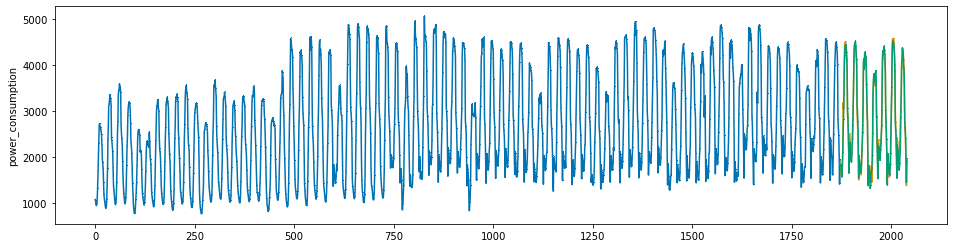

In [58]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

In [59]:
xgb_reg = XGBRegressor(eta = xgb_params.iloc[47,0], min_child_weight = xgb_params.iloc[47,1], 
                       max_depth = xgb_params.iloc[47,2], colsample_bytree = xgb_params.iloc[47,3], 
                       subsample = xgb_params.iloc[47,4], seed=0)

xgb_reg.set_params(**{'objective':weighted_mse(100)})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None,
             objective=<function weighted_mse.<locals>.weighted_mse_fixed at 0x00000181ACC063A0>, ...)

In [11]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

NotFittedError: need to call fit or load_model beforehand

In [16]:
train_2 = train
test_2 = test

# 카테고리 컬럼 설정
# train_2[['building_type']] = train_2[[ 'building_type']].astype('category')
# train_2 = pd.get_dummies(train_2, columns = ['building_type'])

scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    y = train_2.loc[train['building_number'] == i+1, 'power_consumption']
    x = train_2.loc[train['building_number'] == i+1].drop(columns = 'power_consumption')
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x_scaled, test_size = 168)
    
    xgb_reg = XGBRegressor(eta = 0.3, min_child_weight = xgb_params.iloc[i, 1],
                           max_depth = xgb_params.iloc[i, 2], colsample_bytree = xgb_params.iloc[i, 3], 
                           subsample = xgb_params.iloc[i, 4], seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정
    
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)   
    
    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
  1%|▊                                                                                 | 1/100 [00:00<00:13,  7.37it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
  2%|█▋                                                                                | 2/100 [00:00<00:15,  6.36it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method

 22%|█████████████████▊                                                               | 22/100 [00:03<00:11,  6.73it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
 23%|██████████████████▋                                                              | 23/100 [00:03<00:11,  6.51it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
 24%|███████████████████▍                                                             | 24/100 [00:03<00:11,  6.65it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method

 44%|███████████████████████████████████▋                                             | 44/100 [00:06<00:08,  6.32it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
 45%|████████████████████████████████████▍                                            | 45/100 [00:06<00:08,  6.59it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
 46%|█████████████████████████████████████▎                                           | 46/100 [00:06<00:07,  6.92it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:09<00:04,  7.29it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:09<00:04,  6.85it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
 68%|███████████████████████████████████████████████████████                          | 68/100 [00:09<00:04,  6.54it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:12<00:02,  5.68it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:13<00:01,  5.73it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:13<00:01,  5.78it/s]C:\Users\yeji4\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method

In [63]:
best_it

[39,
 8,
 9,
 8,
 70,
 42,
 11,
 57,
 99,
 7,
 65,
 99,
 11,
 9,
 89,
 9,
 99,
 32,
 17,
 48,
 85,
 27,
 23,
 85,
 30,
 96,
 99,
 7,
 64,
 46,
 70,
 95,
 70,
 25,
 48,
 32,
 16,
 14,
 40,
 9,
 50,
 5,
 81,
 9,
 92,
 64,
 63,
 96,
 49,
 86,
 63,
 94,
 26,
 10,
 48,
 27,
 11,
 62,
 77,
 9,
 17,
 87,
 39,
 89,
 59,
 56,
 5,
 85,
 10,
 99,
 26,
 96,
 11,
 33,
 28,
 96,
 65,
 94,
 52,
 43,
 46,
 93,
 24,
 24,
 91,
 65,
 24,
 21,
 13,
 32,
 37,
 40,
 56,
 16,
 7,
 10,
 17,
 39,
 8,
 21]

In [17]:
df['iteration'] = best_it

In [14]:
df

eta min_child_weight max_depth  colsample_bytree  subsample  iteration
0   0.3                5         4               0.8        0.8         89
0   0.3                6         8               0.8        0.6         10
0   0.3                4         7               0.8        0.8         21
0   0.3                5         8               0.8        0.8         11
0   0.3                2         5               0.8        0.8         21
..  ...              ...       ...               ...        ...        ...
0   0.3                1         7               0.8        0.4         21
0   0.3                6         8               0.8        0.6         47
0   0.3                3         3               0.8        0.4         97
0   0.3                2         3               0.8        0.8         61
0   0.3                5         3               0.8        0.6         95

[100 rows x 6 columns]

In [31]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [37]:
import time
import itertools 

In [18]:
train_3 = train
test_3 = test

# 카테고리 컬럼 설정
# train_3[['building_type']] = train_3[[ 'building_type']].astype('category')
# train_3 = pd.get_dummies(train_3, columns = ['building_type'])

alpha_list = []
smape_list = []

for i in tqdm(range(100)):
    y = train_3.loc[train['building_number'] == i+1, 'power_consumption']
    x = train_3.loc[train['building_number'] == i+1].drop(columns = 'power_consumption')
    
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x_scaled, test_size = 168)
    
    xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.3, min_child_weight = df.iloc[i, 1],
                      max_depth = df.iloc[i, 2], colsample_bytree = df.iloc[i, 3], subsample = df.iloc[i, 4])
    
    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    best_alpha = 0
    score0 = SMAPE(y_test,pred0)
    
    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.3, min_child_weight = df.iloc[i, 1],
                      max_depth = df.iloc[i, 2], colsample_bytree = df.iloc[i, 3], subsample = df.iloc[i, 4])
        xgb.set_params(**{'objective' : weighted_mse(j)})
    
        xgb.fit(x_train, y_train)
        pred1 = xgb.predict(x_test)
        score1 = SMAPE(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1
    
    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))

  2%|█▋                                                                                | 2/100 [00:00<00:14,  6.93it/s]

building 1 || best score : 9.132709346130515 || alpha : 1
building 2 || best score : 9.593818436767897 || alpha : 100


  4%|███▎                                                                              | 4/100 [00:00<00:18,  5.21it/s]

building 3 || best score : 10.847515502302086 || alpha : 0
building 4 || best score : 4.178575535356812 || alpha : 75


  6%|████▉                                                                             | 6/100 [00:01<00:24,  3.90it/s]

building 5 || best score : 7.843980715362786 || alpha : 0
building 6 || best score : 4.151460598046039 || alpha : 5


  8%|██████▌                                                                           | 8/100 [00:01<00:19,  4.73it/s]

building 7 || best score : 9.59603925963942 || alpha : 7
building 8 || best score : 5.25014345421558 || alpha : 10


 10%|████████                                                                         | 10/100 [00:01<00:14,  6.08it/s]

building 9 || best score : 5.788983285898771 || alpha : 3
building 10 || best score : 7.594065814456348 || alpha : 50


 11%|████████▉                                                                        | 11/100 [00:02<00:15,  5.57it/s]

building 11 || best score : 3.485781977882253 || alpha : 7


 12%|█████████▋                                                                       | 12/100 [00:02<00:29,  3.02it/s]

building 12 || best score : 4.191209667427265 || alpha : 0


 14%|███████████▎                                                                     | 14/100 [00:03<00:23,  3.60it/s]

building 13 || best score : 7.131276321944019 || alpha : 100
building 14 || best score : 15.081497489112 || alpha : 0


 16%|████████████▉                                                                    | 16/100 [00:03<00:17,  4.92it/s]

building 15 || best score : 4.186804910012091 || alpha : 100
building 16 || best score : 6.823181638475064 || alpha : 3


 18%|██████████████▌                                                                  | 18/100 [00:04<00:21,  3.80it/s]

building 17 || best score : 6.310501740764077 || alpha : 0
building 18 || best score : 7.74202863970538 || alpha : 3


 19%|███████████████▍                                                                 | 19/100 [00:04<00:18,  4.28it/s]

building 19 || best score : 9.5133532726555 || alpha : 0


 21%|█████████████████                                                                | 21/100 [00:04<00:17,  4.41it/s]

building 20 || best score : 6.357339395146592 || alpha : 1
building 21 || best score : 8.663169097494096 || alpha : 3


 22%|█████████████████▊                                                               | 22/100 [00:05<00:28,  2.70it/s]

building 22 || best score : 4.653554355212197 || alpha : 0


 23%|██████████████████▋                                                              | 23/100 [00:06<00:31,  2.44it/s]

building 23 || best score : 1.8255294511937334 || alpha : 1


 24%|███████████████████▍                                                             | 24/100 [00:06<00:34,  2.21it/s]

building 24 || best score : 2.658686044288798 || alpha : 0


 25%|████████████████████▎                                                            | 25/100 [00:07<00:47,  1.57it/s]

building 25 || best score : 2.6851261929836516 || alpha : 7
building 26 || best score : 2.283420988600178 || alpha : 10

 27%|█████████████████████▊                                                           | 27/100 [00:08<00:29,  2.46it/s]


building 27 || best score : 2.179307757742282 || alpha : 3


 29%|███████████████████████▍                                                         | 29/100 [00:08<00:19,  3.66it/s]

building 28 || best score : 6.164707187736583 || alpha : 0
building 29 || best score : 5.179143754799253 || alpha : 10


 31%|█████████████████████████                                                        | 31/100 [00:09<00:21,  3.26it/s]

building 30 || best score : 7.337054535793867 || alpha : 0
building 31 || best score : 5.210861860994225 || alpha : 0


 32%|█████████████████████████▉                                                       | 32/100 [00:09<00:18,  3.65it/s]

building 32 || best score : 0.4280043694284329 || alpha : 0


 33%|██████████████████████████▋                                                      | 33/100 [00:09<00:18,  3.59it/s]

building 33 || best score : 0.32519105770286566 || alpha : 5


 34%|███████████████████████████▌                                                     | 34/100 [00:09<00:17,  3.72it/s]

building 34 || best score : 0.6124635331497904 || alpha : 100


 35%|████████████████████████████▎                                                    | 35/100 [00:10<00:16,  3.96it/s]

building 35 || best score : 0.4764910074561319 || alpha : 75


 36%|█████████████████████████████▏                                                   | 36/100 [00:10<00:16,  3.84it/s]

building 36 || best score : 0.5075865686677735 || alpha : 0


 38%|██████████████████████████████▊                                                  | 38/100 [00:11<00:21,  2.90it/s]

building 37 || best score : 5.3041364842510035 || alpha : 0
building 38 || best score : 6.551840947419299 || alpha : 3


 39%|███████████████████████████████▌                                                 | 39/100 [00:11<00:18,  3.30it/s]

building 39 || best score : 7.9322636361983205 || alpha : 7


 40%|████████████████████████████████▍                                                | 40/100 [00:11<00:18,  3.21it/s]

building 40 || best score : 11.17317399963323 || alpha : 0


 42%|██████████████████████████████████                                               | 42/100 [00:12<00:19,  3.03it/s]

building 41 || best score : 5.408498313118967 || alpha : 0
building 42 || best score : 19.492447755367927 || alpha : 10


 44%|███████████████████████████████████▋                                             | 44/100 [00:13<00:16,  3.34it/s]

building 43 || best score : 6.1438591865507135 || alpha : 0
building 44 || best score : 7.718351319502273 || alpha : 0


 46%|█████████████████████████████████████▎                                           | 46/100 [00:13<00:12,  4.23it/s]

building 45 || best score : 2.391396219585898 || alpha : 5
building 46 || best score : 5.795664046910165 || alpha : 10


 48%|██████████████████████████████████████▉                                          | 48/100 [00:14<00:10,  4.96it/s]

building 47 || best score : 5.165320582996242 || alpha : 100
building 48 || best score : 2.5512425975800137 || alpha : 10


 50%|████████████████████████████████████████▌                                        | 50/100 [00:14<00:09,  5.09it/s]

building 49 || best score : 2.8210386860301164 || alpha : 75
building 50 || best score : 3.9575453201850532 || alpha : 10


 52%|██████████████████████████████████████████                                       | 52/100 [00:15<00:17,  2.73it/s]

building 51 || best score : 3.5387016561659004 || alpha : 0
building 52 || best score : 3.896436357842889 || alpha : 75


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:16<00:26,  1.76it/s]

building 53 || best score : 11.293006224076953 || alpha : 0


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:17<00:19,  2.35it/s]

building 54 || best score : 20.240204504511304 || alpha : 0
building 55 || best score : 1.6825144799125047 || alpha : 5


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:17<00:15,  2.81it/s]

building 56 || best score : 0.7718536442884741 || alpha : 25


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:18<00:26,  1.60it/s]

building 57 || best score : 5.566207507775189 || alpha : 0


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:19<00:16,  2.50it/s]

building 58 || best score : 0.4510811037381872 || alpha : 100
building 59 || best score : 7.484256114954234 || alpha : 7


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:19<00:12,  3.17it/s]

building 60 || best score : 7.187770667703481 || alpha : 25


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:20<00:13,  2.75it/s]

building 61 || best score : 4.2644099800689155 || alpha : 0
building 62 || best score : 5.788089695392803 || alpha : 3


 63%|███████████████████████████████████████████████████                              | 63/100 [00:21<00:20,  1.82it/s]

building 63 || best score : 6.161689027184682 || alpha : 5


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:22<00:26,  1.37it/s]

building 64 || best score : 3.754888174170179 || alpha : 0


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:23<00:30,  1.16it/s]

building 65 || best score : 8.514533330229938 || alpha : 0


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:23<00:17,  1.90it/s]

building 66 || best score : 5.377530260458635 || alpha : 1
building 67 || best score : 6.794228790859264 || alpha : 10


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:24<00:13,  2.32it/s]

building 68 || best score : 4.280604133015423 || alpha : 0


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:25<00:24,  1.29it/s]

building 69 || best score : 3.1043159681004293 || alpha : 0


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:26<00:15,  1.84it/s]

building 70 || best score : 2.936595882312161 || alpha : 0
building 71 || best score : 5.59218538877309 || alpha : 25


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:26<00:10,  2.68it/s]

building 72 || best score : 3.986866065756477 || alpha : 75
building 73 || best score : 3.3153009698438463 || alpha : 5


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:28<00:13,  1.88it/s]

building 74 || best score : 5.95969114745437 || alpha : 0
building 75 || best score : 4.670269072298453 || alpha : 75


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:28<00:07,  2.94it/s]

building 76 || best score : 5.34515234929093 || alpha : 5
building 77 || best score : 4.2688195726893365 || alpha : 0


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:29<00:09,  2.30it/s]

building 78 || best score : 3.589248381103228 || alpha : 1
building 79 || best score : 3.6330855066783463 || alpha : 25


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:30<00:06,  2.80it/s]

building 80 || best score : 4.820939531387693 || alpha : 0
building 81 || best score : 5.5072358376921375 || alpha : 1


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:30<00:05,  3.42it/s]

building 82 || best score : 6.595198091558557 || alpha : 7


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:31<00:09,  1.77it/s]

building 83 || best score : 3.690642328644106 || alpha : 0


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:32<00:11,  1.40it/s]

building 84 || best score : 3.228663744244779 || alpha : 0


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:33<00:07,  1.96it/s]

building 85 || best score : 3.2004117548889432 || alpha : 0
building 86 || best score : 6.276400598106527 || alpha : 75


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:33<00:05,  2.20it/s]

building 87 || best score : 10.334696016069039 || alpha : 100


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:34<00:03,  2.93it/s]

building 88 || best score : 7.078099861531861 || alpha : 0
building 89 || best score : 7.55744799163707 || alpha : 10


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:34<00:03,  3.18it/s]

building 90 || best score : 9.088667028819655 || alpha : 0


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:35<00:02,  3.03it/s]

building 91 || best score : 12.564226044897605 || alpha : 0


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:35<00:01,  3.93it/s]

building 92 || best score : 6.114922703451374 || alpha : 0
building 93 || best score : 7.168250341161757 || alpha : 0


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:35<00:00,  5.03it/s]

building 94 || best score : 6.452453166874535 || alpha : 75
building 95 || best score : 15.993984958362809 || alpha : 3


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:35<00:00,  5.18it/s]

building 96 || best score : 3.674446530685066 || alpha : 1


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:36<00:00,  5.01it/s]

building 97 || best score : 5.609159927734223 || alpha : 0
building 98 || best score : 12.789401189278294 || alpha : 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]

building 99 || best score : 4.744295513085768 || alpha : 0
building 100 || best score : 6.922021089759853 || alpha : 0


In [19]:
df['alpha'] = alpha_list

In [45]:
df

eta min_child_weight max_depth  colsample_bytree  subsample  iteration  \
0   0.3                5         4               0.8        0.8          9   
0   0.3                6         8               0.8        0.6          8   
0   0.3                4         7               0.8        0.8         18   
0   0.3                5         8               0.8        0.8          9   
0   0.3                2         5               0.8        0.8         36   
..  ...              ...       ...               ...        ...        ...   
0   0.3                1         7               0.8        0.4         10   
0   0.3                6         8               0.8        0.6         17   
0   0.3                3         3               0.8        0.4          8   
0   0.3                2         3               0.8        0.8          9   
0   0.3                5         3               0.8        0.6         11   

    alpha  
0       1  
0     100  
0       0  
0      75  
0       0  
..    ...  
0       1  
0       0  
0       0  
0       0  
0       0  

[100 rows x 7 columns]

<BarContainer object of 100 artists>

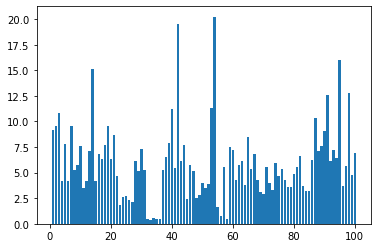

In [46]:
no_df = pd.DataFrame({'score':smape_list})
plt.bar(np.arange(len(no_df))+1, no_df['score'])

In [34]:
smape_list

[4.2322149211128375,
 9.148442672542242,
 9.027213086130024,
 3.348452910453821,
 3.9438801281148996,
 3.5447551277002485,
 6.826024348679725,
 3.956189489419806,
 2.9165771490607053,
 5.16755485709531,
 2.8282538428312503,
 3.264370674898892,
 5.643686104996229,
 13.555437608428237,
 2.2848752351629016,
 4.125739278333614,
 4.570688490745288,
 6.088032278253192,
 6.707249293762269,
 4.149987082464336,
 5.070414482329675,
 3.4567345029611194,
 1.4566384059604505,
 2.4152456041450705,
 1.9613405880310746,
 1.9890328808445403,
 1.4014395205115822,
 4.254009410544535,
 2.6892567920026273,
 6.638874547089199,
 3.7492155011050543,
 0.3081162525262997,
 0.2941374027357093,
 0.6031482128604955,
 0.3477649546340398,
 0.640065764242709,
 4.1861333382927395,
 3.5413112254820414,
 4.065067749903509,
 8.774158613976486,
 3.657611189549163,
 23.54050230090696,
 5.119103692957448,
 3.547680845736853,
 1.9018444568669362,
 4.116062690353154,
 3.6008263029588954,
 1.8692218566805505,
 1.82113855739769

In [47]:
for i in range(len(smape_list)):
    if smape_list[i] > 10:
        print(i+1)

3
14
40
42
53
54
87
91
95
98


* 3번 건물 확인

In [70]:
train_1 = train
test_1 = test

# 카테고리 컬럼 설정
# train_1[['building_type']] = train_1[[ 'building_type']].astype('category')

# train_1 = pd.get_dummies(train_1, columns = ['building_type'])

# 특성과 라벨 분리
y = train_1.loc[train['building_number'] == 3, 'power_consumption']
x = train_1.loc[train['building_number'] == 3].drop(columns = ['building_number','power_consumption', 'weekend'])

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(np.array(x))

# scaler = RobustScaler()
# X_train_scaled_1 = scaler.fit_transform(x)

# 데이터 분할
y_train, y_valid, X_train_scaled_1, x_valid = temporal_train_test_split(y = y, X = X_train_scaled_1, test_size = 168)

# XGBoost 모델 생성
xgb_model_1 = XGBRegressor(objective='reg:squarederror', random_state=42, eta = 0.3, min_child_weight = 4, max_depth = 7, 
                          colsample_bytree = 0.8, subsample = 0.8, n_estimators = 18)

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_1.fit(X_train_scaled_1,y_train )

pred = xgb_model_1.predict(x_valid)
print(f"SMAPE: {smape(y_valid, pred)}")

feature_importance = pd.DataFrame(xgb_model_1.feature_importances_.reshape((1, -1)), columns=x.columns, index=['feature_importance'])
feature_importance = feature_importance.transpose()
feature_importance

SMAPE: 13.863715502728603


feature_importance
temperature                    0.002537
windspeed                      0.003249
humidity                       0.019807
day                            0.031729
month                          0.085941
day_of_week                    0.004864
cos_time                       0.005792
sin_time                       0.004447
holiday                        0.023748
discomfort                     0.009727
discomfort_3                   0.006233
CDH                            0.012131
sensory_temperature            0.008947
month_day_hour_mean            0.742169
day_hour_mean                  0.022941
hour_mean                      0.005949
hour_std                       0.009790

In [71]:
train_1 = train
test_1 = test

# 카테고리 컬럼 설정
# train_1[['building_type']] = train_1[[ 'building_type']].astype('category')

# train_1 = pd.get_dummies(train_1, columns = ['building_type'])

# 특성과 라벨 분리
y = train_1.loc[train['building_number'] == 14, 'power_consumption']
x = train_1.loc[train['building_number'] == 14].drop(columns = ['building_number','power_consumption', 'weekend'])

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(np.array(x))

# scaler = RobustScaler()
# X_train_scaled_1 = scaler.fit_transform(x)

# 데이터 분할
y_train, y_valid, X_train_scaled_1, x_valid = temporal_train_test_split(y = y, X = X_train_scaled_1, test_size = 168)

# XGBoost 모델 생성
xgb_model_1 = XGBRegressor(objective='reg:squarederror', random_state=42, eta = 0.3, min_child_weight = 1, max_depth = 6, 
                          colsample_bytree = 0.4, subsample = 0.4, n_estimators = 6)

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_1.fit(X_train_scaled_1,y_train )

pred = xgb_model_1.predict(x_valid)
print(f"SMAPE: {smape(y_valid, pred)}")

feature_importance = pd.DataFrame(xgb_model_1.feature_importances_.reshape((1, -1)), columns=x.columns, index=['feature_importance'])
feature_importance = feature_importance.transpose()
feature_importance

SMAPE: 15.912529966866334


feature_importance
temperature                    0.014726
windspeed                      0.000000
humidity                       0.000000
day                            0.053196
month                          0.070689
day_of_week                    0.025873
cos_time                       0.008379
sin_time                       0.020928
holiday                        0.027489
discomfort                     0.022054
discomfort_3                   0.015968
CDH                            0.034944
sensory_temperature            0.013705
month_day_hour_mean            0.302700
day_hour_mean                  0.194217
hour_mean                      0.174095
hour_std                       0.021036

In [71]:
df

eta min_child_weight max_depth  colsample_bytree  subsample  iteration  \
0   0.3                7         5               0.8        0.6         39   
0   0.3                1         8               0.6        0.8          8   
0   0.3                2         8               0.6        0.8          9   
0   0.3                5         8               0.8        0.8          8   
0   0.3                3         4               0.6        0.6         70   
..  ...              ...       ...               ...        ...        ...   
0   0.3                3         6               0.4        0.8         10   
0   0.3                5         8               0.8        0.6         17   
0   0.3                2         8               0.6        0.4         39   
0   0.3                1         3               0.6        0.6          8   
0   0.3                2         3               0.4        0.8         21   

    alpha  
0       0  
0      10  
0       0  
0      50  
0       0  
..    ...  
0       1  
0       0  
0       0  
0     100  
0       0  

[100 rows x 7 columns]

In [30]:
building = pd.read_csv("building_info.csv", encoding = 'utf-8')
building.to_csv("building_info.csv", encoding = 'cp949')

In [24]:
train_3.loc[(train_3.building_number == 2)| (train_3.building_number == 3)|(train_3.building_number == 7)
           |(train_3.building_number ==14)|(train_3.building_number ==40)|(train_3.building_number ==42)
           |(train_3.building_number ==53)|(train_3.building_number ==54)|(train_3.building_number ==89)
           |(train_3.building_number ==91)|(train_3.building_number ==95)|(train_3.building_number ==98),]

building_number  temperature  windspeed  humidity  power_consumption  \
2040                  2         18.6        0.9      42.0            1170.36   
2041                  2         18.0        1.1      45.0            1146.96   
2042                  2         17.7        1.5      45.0            1115.28   
2043                  2         16.7        1.4      48.0            1107.00   
2044                  2         18.4        2.8      43.0            1069.92   
...                 ...          ...        ...       ...                ...   
199915               98         21.6        2.6      79.0            1107.00   
199916               98         21.2        1.2      84.0            1053.18   
199917               98         21.3        1.4      84.0             971.82   
199918               98         21.0        1.1      86.0             815.94   
199919               98         21.0        1.0      86.0             632.34   

        day  month  day_of_week  cos_time  sin_time  ...  \
2040      1      6            2  1.000000  0.000000  ...   
2041      1      6            2  0.965926  0.258819  ...   
2042      1      6            2  0.866025  0.500000  ...   
2043      1      6            2  0.707107  0.707107  ...   
2044      1      6            2  0.500000  0.866025  ...   
...     ...    ...          ...       ...       ...  ...   
199915   24      8            2  0.258819 -0.965926  ...   
199916   24      8            2  0.500000 -0.866025  ...   
199917   24      8            2  0.707107 -0.707107  ...   
199918   24      8            2  0.866025 -0.500000  ...   
199919   24      8            2  0.965926 -0.258819  ...   

        building_type_Data Center  building_type_Department Store and Outlet  \
2040                            0                                          0   
2041                            0                                          0   
2042                            0                                          0   
2043                            0                                          0   
2044                            0                                          0   
...                           ...                                        ...   
199915                          0                                          0   
199916                          0                                          0   
199917                          0                                          0   
199918                          0                                          0   
199919                          0                                          0   

        building_type_Discount Mart  building_type_Hospital  \
2040                              0                       0   
2041                              0                       0   
2042                              0                       0   
2043                              0                       0   
2044                              0                       0   
...                             ...                     ...   
199915                            0                       0   
199916                            0                       0   
199917                            0                       0   
199918                            0                       0   
199919                            0                       0   

        building_type_Hotel and Resort  \
2040                                 0   
2041                                 0   
2042                                 0   
2043                                 0   
2044                                 0   
...                                ...   
199915                               1   
199916                               1   
199917                               1   
199918                               1   
199919                               1   

        building_type_Knowledge Industry Center  \
2040                                          0   
2

In [39]:
no_df.describe()

score
count  100.000000
mean     5.572426
std      3.770119
min      0.346773
25%      3.377486
50%      4.838860
75%      6.840043
max     21.379405

In [75]:
no_df

score
0    6.819179
1   10.047074
2   11.378956
3    3.637724
4    7.936575
..        ...
95   2.566494
96   4.367800
97  13.096890
98   4.498470
99   5.777735

[100 rows x 1 columns]

In [22]:
df.to_csv("parameter_final.csv", index = False)

In [56]:
xgb_params = pd.read_csv("parameter_final.csv")

In [74]:
xgb_params

eta  min_child_weight  max_depth  colsample_bytree  subsample  iteration  \
0   0.3                 7          5               0.8        0.6         39   
1   0.3                 1          8               0.6        0.8          8   
2   0.3                 2          8               0.6        0.8          9   
3   0.3                 5          8               0.8        0.8          8   
4   0.3                 3          4               0.6        0.6         70   
..  ...               ...        ...               ...        ...        ...   
95  0.3                 3          6               0.4        0.8         10   
96  0.3                 5          8               0.8        0.6         17   
97  0.3                 2          8               0.6        0.4         39   
98  0.3                 1          3               0.6        0.6          8   
99  0.3                 2          3               0.4        0.8         21   

    alpha  
0       0  
1      10  
2       0  
3      50  
4       0  
..    ...  
95      1  
96      0  
97      0  
98    100  
99      0  

[100 rows x 7 columns]

In [75]:
train = pd.read_csv("pre_ver7/pre_train.csv")
test = pd.read_csv("pre_ver7/pre_test.csv")

In [57]:
train_4 = train
test_4 = test

# # 카테고리 컬럼 설정
# train_4[['building_type']] = train_4[[ 'building_type']].astype('category')
# #test_4[['building_type']] = test_4[['building_type']].astype('category')

# train_4 = pd.get_dummies(train_4, columns = ['building_type'])
# #test_4 = pd.get_dummies(test_4, columns = ['building_type'])


In [77]:
from tqdm import tqdm

In [58]:
preds = np.array([]) 
# from sklearn.preprocessing import RobustScaler
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()  
    
    for seed in [0,1,2,3,4,5]: 
        y_train = train_4.loc[train_4['building_number'] == i+1, 'power_consumption']
        x_train = train_4.loc[train_4['building_number'] == i+1].drop(columns = ['building_number','power_consumption'])
        x_test = test_4.drop(columns = 'building_number')
        
        # 데이터 정규화
        scaler = StandardScaler()
        X_train_scaled= scaler.fit_transform(np.array(x_train))
#         robustScaler = RobustScaler()
#         X_train_scaled = robustScaler.fit_transform(x_train)
        #y_train_scaled=scaler.fit_transform(np.array(y_train).reshape(-1, 1))
        
        xgb = XGBRegressor(seed = seed, n_estimators = xgb_params.iloc[i,5] , eta = 0.3, 
                           min_child_weight = xgb_params.iloc[i, 1], max_depth = xgb_params.iloc[i, 2], 
                           colsample_bytree=xgb_params.iloc[i, 3], subsample=xgb_params.iloc[i, 4])
    
        if xgb_params.iloc[i,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb.set_params(**{'objective':weighted_mse(xgb_params.iloc[i,6])})
        
        xgb.fit(X_train_scaled, y_train)
        x_test = scaler.fit_transform(x_test)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s]


In [59]:
preds

array([2320.71484375, 2281.93041992, 2167.52416992, ...,  636.1817627 ,
        625.69366455,  602.50213623])

In [60]:
preds = pd.Series(preds)

fig, ax = plt.subplots(100, 1, figsize=(100,200), sharex = True)
ax = ax.flatten()
for i in tqdm(range(100)):
    train_y = train_4.loc[train_4.building_number == i+1, 'power_consumption'].reset_index(drop = True)
    test_y = preds[i*168:(i+1)*168]
    ax[i].scatter(np.arange(2040) , train_4.loc[train_4.building_number == i+1, 'power_consumption'])
    ax[i].scatter(np.arange(2040, 2040+168) , test_y)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='minor', labelsize=4)
plt.savefig('./predict_xgb.png')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.26it/s]


In [27]:
preds = pd.Series(preds)

fig, ax = plt.subplots(100, 1, figsize=(100,200), sharex = True)
ax = ax.flatten()
for i in tqdm(range(100)):
    train_y = train_4.loc[train_4.building_number == i+1, 'power_consumption'].reset_index(drop = True)
    test_y = preds[i*168:(i+1)*168]
    ax[i].scatter(np.arange(2040) , train_4.loc[train_4.building_number == i+1, 'power_consumption'])
    ax[i].scatter(np.arange(2040, 2040+168) , test_y)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='minor', labelsize=4)
    
plt.savefig('./predict_xgb.png')
plt.show()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.82it/s]


<Figure size 432x288 with 0 Axes>

In [73]:
preds = np.array([]) 
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()  
    
    for seed in [0,1,2,3,4,5]: 
        y_train = train_4.loc[train_4['building_number'] == i+1, 'power_consumption']
        x_train = train_4.loc[train_4['building_number'] == i+1].drop(columns = 'power_consumption')
        x_test = test_4
        
        xgb = XGBRegressor(seed = seed, n_estimators = best_it[i], eta = 0.01, 
                           min_child_weight = xgb_params.iloc[i, 2], max_depth = xgb_params.iloc[i, 3], 
                           colsample_bytree=xgb_params.iloc[i, 4], subsample=xgb_params.iloc[i, 5])
    
#         if xgb_params.iloc[i,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
#             xgb.set_params(**{'objective':weighted_mse(xgb_params.iloc[i,6])})
        
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)   

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:11<00:00,  6.11s/it]


In [48]:
submission = pd.read_csv('sample_submission.csv')
submission['answer'] = preds
submission.to_csv('submission_xgb_noclip.csv', index = False)

In [69]:
train_5 = train
test_5 = test

# 카테고리 컬럼 설정
train_5[['building_type']] = train_5[[ 'building_type']].astype('category')
test_5[['building_type']] = test_5[['building_type']].astype('category')

train_5 = pd.get_dummies(train_5, columns = ['building_type'])
test_5 = pd.get_dummies(test_5, columns = ['building_type'])

## submission 불러오기
df = pd.read_csv('submission_xgb_02.csv')
for i in range(100):
    min_data = train_5.loc[train_5.building_number == i+1, ].iloc[-28*24:, :]
    ## 요일별, 시간대별 최솟값 계산
    min_data = pd.pivot_table(min_data, values = 'power_consumption', index = ['day', 'hour'], aggfunc = min).reset_index() 
    pred = df.answer[168*i:168*(i+1)].reset_index(drop=True) ## 168개 데이터, 즉 건물별 예측값 불러오기
    day =  test_5.day[168*i:168*(i+1)].reset_index(drop=True) ## 예측값 요일 불러오기
    hour = test_5.hour[168*i:168*(i+1)].reset_index(drop=True) ## 예측값 시간 불러오기
    df_pred = pd.concat([pred, day, hour], axis = 1)
    df_pred.columns = ['pred', 'day', 'hour']
    for j in range(len(df_pred)):
        min_power = min_data.loc[(min_data.day == df_pred.day[j])&(min_data.hour == df_pred.hour[j]), 'power_consumption'].values[0]
        if df_pred.pred[j] < min_power:
            pred_clip.append(min_power)
        else:
            pred_clip.append(df_pred.pred[j])

KeyError: 'hour'